In [6]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# import tensorflow dependenciess
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

2024-09-21 22:29:27.817579: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-21 22:29:29.867378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
gpus = tf.config.experimental.list_physical_devices('gpu')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2024-09-21 22:29:33.259593: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [9]:
# setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [10]:
# make the directeries
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [11]:
# https://vis-www.cs.umass.edu/lfw/
import os

# Define paths
POS_PATH = "positive"
NEG_PATH = "negative"
ANC_PATH = "anchor"

# Check if directories exist, if not create them
if not os.path.exists(POS_PATH):
    os.makedirs(POS_PATH)

if not os.path.exists(NEG_PATH):
    os.makedirs(NEG_PATH)

if not os.path.exists(ANC_PATH):
    os.makedirs(ANC_PATH)


In [12]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [13]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('/home/arunish/Desktop/python-ws/lfw/'):
    for file in os.listdir(os.path.join('/home/arunish/Desktop/python-ws/lfw/', directory)):
        EX_PATH = os.path.join('/home/arunish/Desktop/python-ws/lfw/', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [14]:
for directory in os.listdir('/home/arunish/Desktop/python-ws/lfw/'):
    for file in os.listdir(os.path.join('/home/arunish/Desktop/python-ws/lfw/', directory)):
        print(os.path.join('/home/arunish/Desktop/python-ws/lfw/',directory,file))
        print(os.path.join(NEG_PATH))

In [15]:
# importing the uuid library  (universally unique identifiers) 
import uuid

In [19]:
import cv2

# Establish the connection to the webcam
cap = cv2.VideoCapture(0)

# Check if the camera opened successfully
if not cap.isOpened():
    print("Error: Could not open camera.")
else:
    while cap.isOpened():
        ret, frame = cap.read()

        # cutting frame to 250*250 px
        frame = frame[120:120+250,200:200+250, :]

        # collecting anchors
        if cv2.waitKey(1) & 0xFF == ord('a'):
            # create the unique file path
            imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))   
            # write out anchor image
            cv2.imwrite(imgname , frame)

        # collecting positive
        if cv2.waitKey(1) & 0xFF == ord('p'):
            # create the unique file path
            imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))   
            # write out positive image
            cv2.imwrite(imgname , frame)            
        
        # Show image back to screen
        cv2.imshow('Image collection', frame)

        # Breaking gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Release the webcam
cap.release()

# Close the image show frame
cv2.destroyAllWindows()

      

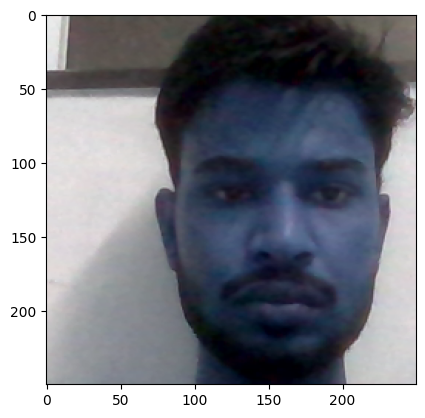

In [20]:
# plt.imshow(frame[120:120+250,200:200+250, :])
plt.imshow(frame)

In [21]:
# Create datasets
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(300)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(300)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(300)


In [22]:
dir_test = anchor.as_numpy_iterator()

In [23]:
dir_test.next()

b'anchor/9da01b16-f264-11ee-ae3a-05c0c8a99752.jpg'

In [24]:
def preprocess(file_path):
    # Read in image file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    # preprocessing images - resize 100*100*3
    img = tf.image.resize(img,(100,100))
    # scaleimages btween 0 and 1
    img = img / 255.0
    # return image
    return img

In [25]:
img = preprocess('anchor/57efbddc-f1e7-11ee-856e-fb9c7795303d.jpg')

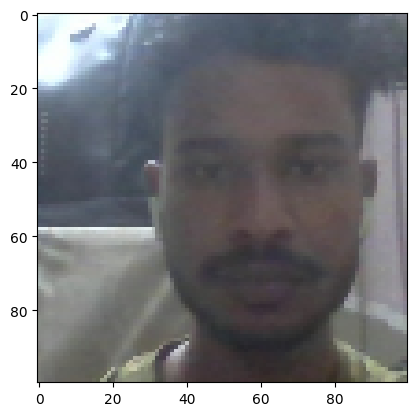

In [26]:
plt.imshow(img)

In [27]:
img.numpy().min()

0.13529412

In [28]:
img.numpy().max()

1.0

In [29]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0
# tf.ones_like([1,1,2,3,3,5555.665])
# tf.ones(len(anchor))
# tf.zeros(len(anchor))

In [30]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [31]:
samples = data.as_numpy_iterator()

In [32]:
example = samples.next()

In [33]:
example

(b'anchor/7ba4fe16-f264-11ee-ae3a-05c0c8a99752.jpg',
 b'positive/962d62fb-f283-11ee-ae3a-05c0c8a99752.jpg',
 1.0)

In [34]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [35]:
res = preprocess_twin(*example)

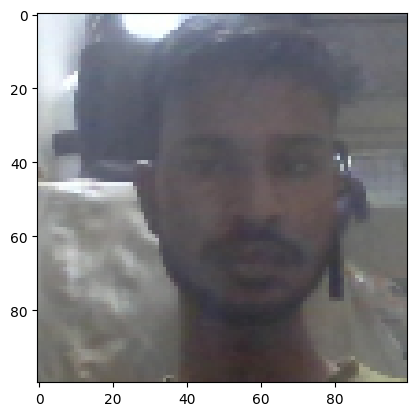

In [36]:
# res[0] 
plt.imshow(res[1])

In [37]:
res[2]

1.0

In [38]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [39]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [40]:
samples = data.as_numpy_iterator()

In [41]:
len(samples.next())

3

In [42]:
samp = samples.next()

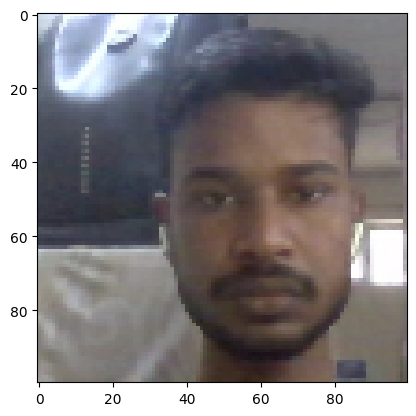

In [43]:
samp = samples.next()   #-->every time run first this then plt.imshow
plt.imshow(samp[0]) 

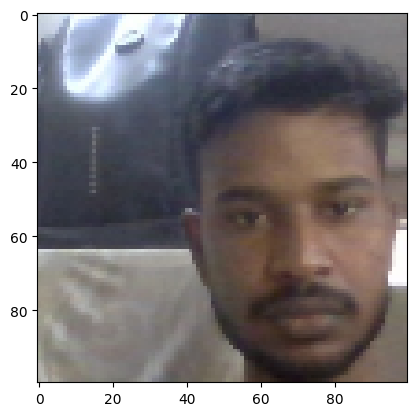

In [44]:
samp = samples.next()
plt.imshow(samp[1])

In [45]:
samp[2]

1.0

In [46]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [47]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [48]:
train_samples = train_data.as_numpy_iterator()

In [49]:
train_sample = train_samples.next()

In [50]:
# len(train_sample) # size of training images anc,neg,pos
len(train_sample[0]) # every batch contain 16 images

16

In [51]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [52]:
 inp = Input(shape = (100,100,3), name='input_image')

In [53]:
c1 = Conv2D(64,(10,10), activation="relu")(inp)

In [54]:
m1 = MaxPooling2D(64,(2,2), padding = "same")(c1)

In [55]:
c2 = Conv2D(128,(7,7),activation= 'relu')(m1)
m2 = MaxPooling2D(64,(2,2), padding = 'same')(c2)

In [56]:
c3 = Conv2D(128,(4,4),activation= 'relu')(m2)
m3 = MaxPooling2D(64,(2,2), padding = 'same')(c3)

In [57]:
c4 = Conv2D(256,(4,4),activation= 'relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

2024-09-21 22:30:57.401134: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2024-09-21 22:30:57.530430: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2024-09-21 22:30:57.556603: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.


In [58]:
mod = Model(inputs = [inp] , outputs = [d1], name = 'embedding')

In [59]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')

    # First block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D((2, 2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D((2, 2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D((2, 2), padding='same')(c3)

    # Final embedding
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=inp, outputs=d1, name='embedding')

# # Create the embedding model
# embedding_model = make_embedding()

# # Print model summary
# embedding_model.summary()

   

In [61]:
embedding = make_embedding()

2024-09-21 22:30:58.488594: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2024-09-21 22:30:58.610681: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.


In [62]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:

# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [64]:
l1 = L1Dist()

In [65]:
l1

<L1Dist name=l1_dist, built=False>

In [66]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # combine siamese distance
    siamese_layer = L1Dist() 
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

   # classifier
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs = classifier , name = 'SiameseNetwork')
    

In [67]:
siamese_model = make_siamese_model()

In [68]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
#setup loss and optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [70]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [71]:
# establish the checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamesse_model=siamese_model)

In [72]:
# Build train step model
test_batch = train_data.as_numpy_iterator()

In [73]:
batch_1 = test_batch.next()

In [74]:
X = batch_1[:2]

In [75]:
y = batch_1[2]

In [76]:
y

array([0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
      dtype=float32)

In [77]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](https://en.wikipedi

In [78]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [79]:
# # BUILD TRAIN LOOOP
# def train(data, EPOCHS):
#     # Loop through epochs
#     for epoch in range(1, EPOCHS+1):
#         print('\n Epoch {}/{}'.format(epoch, EPOCHS))
#         progbar = tf.keras.utils.Progbar(len(data))
        
#         # Loop through each batch
#         for idx, batch in enumerate(data):
#             # Run train step here
#             train_step(batch)
#             progbar.update(idx+1)
        
#         # Save checkpoints
#         if epoch % 10 == 0: 
#             checkpoint.save(file_prefix=checkpoint_prefix)

In [80]:
# # Train the model
# EPOCHS = 50

In [81]:
# train(train_data, EPOCHS)

In [82]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS + 1):
        print('\nEpoch {}/{}'.format(epoch, EPOCHS))
        
        # Initialize metrics
        total_loss = 0.0
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step and calculate loss
            batch_loss = train_step(batch)
            
            # Accumulate batch loss
            total_loss += batch_loss
        
        # Calculate average loss
        average_loss = total_loss / (idx + 1)
        print('Average Loss: {:.4f}'.format(average_loss))
        
        # Save checkpoints every 10 epochs
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)


In [83]:
EPOCHS = 10

In [84]:
train(train_data, EPOCHS)


Epoch 1/10
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)


2024-09-21 22:32:02.578528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Loss: 0.3840

Epoch 2/10


2024-09-21 22:32:53.197449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Loss: 0.1392

Epoch 3/10


2024-09-21 22:33:43.342355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Loss: 0.0668

Epoch 4/10


2024-09-21 22:34:33.788038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Loss: 0.0366

Epoch 5/10


2024-09-21 22:35:23.889853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Loss: 0.0167

Epoch 6/10


2024-09-21 22:36:14.243687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Loss: 0.0102

Epoch 7/10


2024-09-21 22:37:04.962303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Loss: 0.0064

Epoch 8/10


2024-09-21 22:37:55.572944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Loss: 0.0021

Epoch 9/10


2024-09-21 22:38:45.682433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Loss: 0.0027

Epoch 10/10


2024-09-21 22:39:35.856813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Loss: 0.0026


In [85]:
# import metrices calcultion
from tensorflow.keras.metrics import Precision , Recall

In [86]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [87]:
# make predictions
predictions = siamese_model.predict([test_input,test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


In [88]:
predictions

array([[1.0751958e-10],
       [9.9835140e-01],
       [8.1506147e-07],
       [2.2962467e-07],
       [9.9772632e-01],
       [8.3107238e-10],
       [9.9999946e-01],
       [9.9999726e-01],
       [9.9909741e-01],
       [9.9999774e-01],
       [1.3294489e-07],
       [6.8067123e-12],
       [4.7070393e-04],
       [9.9999928e-01],
       [1.0000000e+00],
       [9.9998087e-01]], dtype=float32)

In [89]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


In [90]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1]

In [91]:
y_true

array([0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
      dtype=float32)

In [92]:
# creating a metrices
m = Recall()

# calculating the values
m.update_state(y_true,y_hat)

# recall return result
m.result().numpy()

1.0

In [93]:
# creating a metrices
m = Precision()

# calculating the values
m.update_state(y_true,y_hat)

# recall return result
m.result().numpy()

1.0

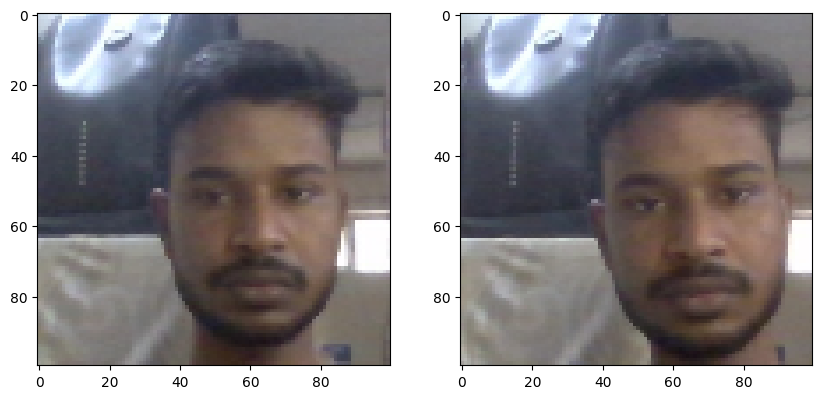

In [94]:
# visualize the reults
plt.figure(figsize=(10,8))
# set teh first subplots
plt.subplot(1,2,1)
plt.imshow(test_input[1]) # [index value from 0....]

# sets the second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])  # [index value from 0....]
#  render cleanly
plt.show()

In [95]:
# Save the model in the recommended Keras format
siamese_model.save('siamesemodelv2.keras', overwrite=True)


In [96]:
# Reload model if saved in the new Keras format
siamese_model = tf.keras.models.load_model('siamesemodelv2.keras', 
                                           custom_objects={'L1Dist': L1Dist, 
                                                           'BinaryCrossentropy': tf.keras.losses.BinaryCrossentropy})


In [97]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


array([[1.0751958e-10],
       [9.9835140e-01],
       [8.1506147e-07],
       [2.2962467e-07],
       [9.9772632e-01],
       [8.3107238e-10],
       [9.9999946e-01],
       [9.9999726e-01],
       [9.9909741e-01],
       [9.9999774e-01],
       [1.3294489e-07],
       [6.8067123e-12],
       [4.7070393e-04],
       [9.9999928e-01],
       [1.0000000e+00],
       [9.9998087e-01]], dtype=float32)

In [98]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
##REAL TIME TEST

In [100]:
"application_data\\verification_images"

'application_data\\verification_images'

In [101]:
os.listdir(os.path.join('application_data', 'verification_images'))

['b4f8873c-f264-11ee-ae3a-05c0c8a99752.jpg',
 '8d86a08b-f283-11ee-ae3a-05c0c8a99752.jpg',
 'a0031ac2-f264-11ee-ae3a-05c0c8a99752.jpg',
 'a134483e-f264-11ee-ae3a-05c0c8a99752.jpg',
 'be65eda4-f264-11ee-ae3a-05c0c8a99752.jpg',
 'bd3488ca-f264-11ee-ae3a-05c0c8a99752.jpg',
 'bc84be5a-f283-11ee-ae3a-05c0c8a99752.jpg',
 'a034655a-f283-11ee-ae3a-05c0c8a99752.jpg',
 'bc03061a-f264-11ee-ae3a-05c0c8a99752.jpg',
 'c52165c0-f283-11ee-ae3a-05c0c8a99752.jpg',
 'bc03060e-f264-11ee-ae3a-05c0c8a99752.jpg',
 '916619f2-f264-11ee-ae3a-05c0c8a99752.jpg',
 'bc030609-f264-11ee-ae3a-05c0c8a99752.jpg',
 'c773c5e8-f283-11ee-ae3a-05c0c8a99752.jpg',
 'be68280e-f283-11ee-ae3a-05c0c8a99752.jpg',
 'bd3488a9-f264-11ee-ae3a-05c0c8a99752.jpg',
 'a1344832-f264-11ee-ae3a-05c0c8a99752.jpg',
 'bd3488a8-f264-11ee-ae3a-05c0c8a99752.jpg',
 'bd3488cd-f264-11ee-ae3a-05c0c8a99752.jpg',
 '1bb47158-f283-11ee-ae3a-05c0c8a99752.jpg',
 'a0031ad3-f264-11ee-ae3a-05c0c8a99752.jpg',
 'bc0305f2-f264-11ee-ae3a-05c0c8a99752.jpg',
 'bc03060f

In [102]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [103]:
 for image in os.listdir(os.path.join('application_data', 'verification_images')):
     validation_img = (os.path.join('application_data', 'verification_images', image))
     print(validation_img)

application_data/verification_images/b4f8873c-f264-11ee-ae3a-05c0c8a99752.jpg
application_data/verification_images/8d86a08b-f283-11ee-ae3a-05c0c8a99752.jpg
application_data/verification_images/a0031ac2-f264-11ee-ae3a-05c0c8a99752.jpg
application_data/verification_images/a134483e-f264-11ee-ae3a-05c0c8a99752.jpg
application_data/verification_images/be65eda4-f264-11ee-ae3a-05c0c8a99752.jpg
application_data/verification_images/bd3488ca-f264-11ee-ae3a-05c0c8a99752.jpg
application_data/verification_images/bc84be5a-f283-11ee-ae3a-05c0c8a99752.jpg
application_data/verification_images/a034655a-f283-11ee-ae3a-05c0c8a99752.jpg
application_data/verification_images/bc03061a-f264-11ee-ae3a-05c0c8a99752.jpg
application_data/verification_images/c52165c0-f283-11ee-ae3a-05c0c8a99752.jpg
application_data/verification_images/bc03060e-f264-11ee-ae3a-05c0c8a99752.jpg
application_data/verification_images/916619f2-f264-11ee-ae3a-05c0c8a99752.jpg
application_data/verification_images/bc030609-f264-11ee-ae3a-05c

In [104]:
# verification function
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified


In [105]:
# openCV for webcam

In [108]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━